In [44]:
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
from plotly import tools
import plotly.graph_objs as go
from lib import lib as l

In [2]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

###  Invest

In [3]:
di = pd.read_csv('br_invest.csv')
di['Data'] = di['Data'].apply(lambda x : dt.datetime.strptime(str(x),'%d/%m/%y').date())
di.head()

,ID,Valor,Data,Status
0,1.000,12491.070,2019-09-27,Aberto
1,1.000,12491.280,2019-09-30,Mes
2,2.000,715.200,2019-10-16,Aberto
3,1.000,12540.010,2019-10-31,Fechado
4,1.100,10940.620,2019-10-31,Aberto


In [58]:
def calc_flux_gain(df):
    o = df.head(1)['Valor'].item()
    f = df.tail(1)['Valor'].item()
    od = df.head(1)['Data'].item()
    of = df.tail(1)['Data'].item()
    gain = f-o
    duration = (of - od).days / 30.5
    total_yield = gain / o
    monthly_yield = (1+total_yield)**(1/duration)-1 if duration > 0 else 0
    annual_yield = (1+monthly_yield)**12-1
    dr = pd.DataFrame({'Valor inicial': [o], 
                       'Ganho': [gain], 
                       'Meses': [duration], 
                       'Rendimento': [total_yield*100],  
                       'Rendimento mensal': [monthly_yield*100], 
                       'Rendimento anual': [annual_yield*100]})
    return dr

####  Yield

In [59]:
dr = di.groupby('ID').apply(calc_flux_gain)
dr = dr.reset_index(level=[0, 1])
dr.pop('level_1')
dr

,ID,Valor inicial,Ganho,Meses,Rendimento,Rendimento mensal,Rendimento anual
0,1.000,12491.070,48.940,1.115,0.392,0.351,4.299
1,1.100,10940.620,41.360,1.279,0.378,0.296,3.605
2,2.000,715.200,2.270,0.951,0.317,0.334,4.080
3,3.000,2002.290,1.620,0.459,0.081,0.176,2.137
4,3.100,1989.980,6.010,0.820,0.302,0.369,4.514
5,4.000,880.000,0.370,0.393,0.042,0.107,1.290
6,4.100,10.100,0.010,0.426,0.099,0.232,2.825
7,5.000,1686.760,0.490,0.295,0.029,0.098,1.188
8,5.100,1060.100,0.000,0.000,0.000,0.000,0.000


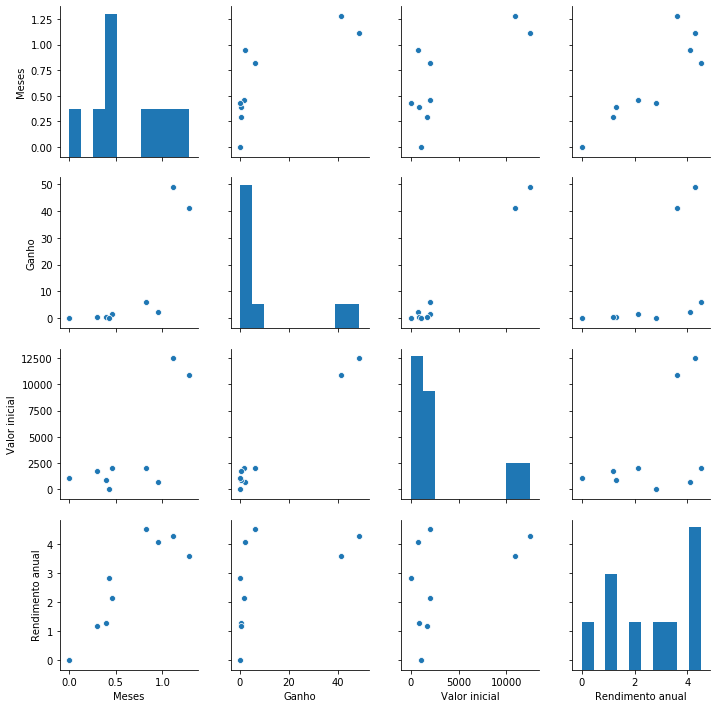

In [60]:
sns.pairplot(dr, vars=['Meses', 'Ganho', 'Valor inicial', 'Rendimento anual'])

In [77]:
def calc_yield(df):
    dl = df[df['Meses'] >= 0.7].copy()
    dl['Prod'] = dl['Rendimento anual'] * dl['Meses']
    lp_yield = dl['Prod'].sum() / dl['Meses'].sum()
    dh = df[df['Meses'] < 0.7].copy()
    dh['Prod'] = dh['Rendimento anual'] * dh['Meses']
    hp_yield = dh['Prod'].sum() / dh['Meses'].sum()
    
    return lp_yield, hp_yield, df['Meses'].mean()

In [78]:
calc_potencial_yield(dr)

(4.078151362476817, 1.9337998875002533, 0.6375227686703097)

###  Transf

In [6]:
dtr = pd.read_csv('br_transf.csv')
dtr

,De,Para,Valor
0,BB,Nu,12491.070
1,Nu,Easy,1455.000
2,Nu,Easy,731.400
3,Nu,Easy,870.270


In [7]:
dtin = l.group_sum(dtr, group=['De'], date=None)
dtin.columns = ['Transferido']
dtout = l.group_sum(dtr, group=['Para'], date=None)
dtout.columns = ['Recebido']

In [8]:
dg = pd.read_csv('br_ganhos.csv')
dg['Data'] = dg['Data'].apply(lambda x : dt.datetime.strptime(str(x),'%d/%m/%y').date())
dg.head()

,Nome,Valor,Data,Conta,Area
0,Grana inicial,12508.530,2019-08-01,BB,Pais
1,Cash,92.000,2019-09-09,Cash,Pais
2,Poupanca BB,9.110,2019-09-20,BB,Investimento
3,Poupanca BB,2.070,2019-09-23,BB,Investimento
4,Poupanca BB,3.820,2019-09-24,BB,Investimento


In [9]:
df = pd.read_csv('br_gastos.csv')
df['Data'] = df['Data'].apply(lambda x : dt.datetime.strptime(str(x),'%d/%m/%y').date())
df.head()

,Nome,Valor,Data,Pagamento,Area,Pessoal
0,Restau Fisica,25.300,2019-09-12,BB,Alimentacao,Sim
1,Bandeco,50.000,2019-09-15,Cash,Alimentacao,Sim
2,Bilhete Unico,30.100,2019-09-15,Pais,Transporte,Sim
3,Impressao apostila,35.000,2019-09-24,Cash,Estudo,Sim
4,Taxa BB,13.250,2019-09-25,BB,Banco,Sim


In [10]:
dgb = l.group_sum(dg, group=['Conta']).sum()['Valor']
dgb.index.name = None
dgb = pd.DataFrame(dgb, columns=['Ganho'])
dgb

,Ganho
Alelo,1123.200
BB,12532.260
Cash,92.000
Easy,140.330
Nu,5375.270


In [11]:
dfb = l.group_sum(df, group=['Pagamento']).sum()['Valor']
dfb.index.name = None
dfb = pd.DataFrame(dfb, columns=['Gasto'])
dfb

,Gasto
Alelo,195.680
BB,41.190
Cash,89.500
Nu,310.520
Pais,10425.333


####  Funds

In [12]:
dmov = dgb.join(dfb).join(dtin).join(dtout)
dmov = dmov.fillna(0)
dmov['Saldo'] = dmov['Ganho'] + dmov['Recebido'] - dmov['Transferido'] - dmov['Gasto']
dmov['Lido'] = [855.51, 0, 269, 3187.3, 14585.12]
dmov['Erro'] = dmov['Saldo'] - dmov['Lido']
dmov.loc[:, ['Saldo', 'Lido', 'Erro']]

,Saldo,Lido,Erro
Alelo,927.520,855.510,72.010
BB,0.000,0.000,0.000
Cash,2.500,269.000,-266.500
Easy,3197.000,3187.300,9.700
Nu,14499.150,14585.120,-85.970


In [13]:
l.group_sum(dg, group=['Area'])

Valor                   
Area   Investimento      Pais  Salario
Ago/19          nan 12508.530      nan
Set/19       23.940    92.000      nan
Out/19       40.320       nan 3279.090
Nov/19      190.820       nan 3128.360

### Area income

In [14]:
l.plot_stacked_area(l.row_percentage(l.group_sum(dg, group=['Area'])))

FigureWidget({
    'data': [{'hoverinfo': 'y+name',
              'line': {'color': 'rgb(0, 0, 0)', 'width': 0…

In [15]:
l.plot_stacked_area(l.group_sum(dg, group=['Area']))

FigureWidget({
    'data': [{'hoverinfo': 'y+name',
              'line': {'color': 'rgb(0, 0, 0)', 'width': 0…

In [16]:
l.plot_pie(l.group_sum(dg, group=['Area']).sum())

FigureWidget({
    'data': [{'hole': 0.4,
              'labels': array(['Investimento', 'Pais', 'Salario'], d…

### Area spendings

In [17]:
spent_ar = l.group_sum(df, group=['Area'])
spent_ar

Valor                                             
Area   Alimentacao  Banco Eletronicos Estudo Moradia Transporte
Set/19     975.300 13.250         nan 35.000 402.333   1230.100
Out/19    1180.610  2.640         nan    nan 402.333   1200.000
Nov/19    1360.610    nan     124.900  4.500 402.333   1200.000
Dez/19     837.000    nan      88.980    nan 402.333   1200.000

In [18]:
spent_ar['Valor']['Alimentacao']

Set/19    975.300
Out/19   1180.610
Nov/19   1360.610
Dez/19    837.000
Name: Alimentacao, dtype: float64

In [19]:
spent_ar.columns.levels[1]

Index(['Alimentacao', 'Banco', 'Eletronicos', 'Estudo', 'Moradia',
       'Transporte'],
      dtype='object', name='Area')

In [20]:
spent_ar.index

Index(['Set/19', 'Out/19', 'Nov/19', 'Dez/19'], dtype='object')

In [21]:
l.plot_stacked_area(l.row_percentage(spent_ar))

FigureWidget({
    'data': [{'hoverinfo': 'y+name',
              'line': {'color': 'rgb(0, 0, 0)', 'width': 0…

In [22]:
l.plot_stacked_area(spent_ar)

FigureWidget({
    'data': [{'hoverinfo': 'y+name',
              'line': {'color': 'rgb(0, 0, 0)', 'width': 0…

In [23]:
l.plot_pie(l.group_sum(df, group=['Area']).sum())

FigureWidget({
    'data': [{'hole': 0.4,
              'labels': array(['Alimentacao', 'Banco', 'Eletronicos'…

In [24]:
l.group_sum(df[df['Pagamento'] != 'Pais'], group=['Area'])

Valor                          
Area   Alimentacao  Banco Eletronicos Estudo
Set/19      75.300 13.250         nan 35.000
Out/19     193.610  2.640         nan    nan
Nov/19     223.610    nan         nan  4.500
Dez/19         nan    nan      88.980    nan

In [25]:
l.plot_stacked_area(l.row_percentage(l.group_sum(df[df['Pagamento'] != 'Pais'], group=['Area'])))

FigureWidget({
    'data': [{'hoverinfo': 'y+name',
              'line': {'color': 'rgb(0, 0, 0)', 'width': 0…

In [26]:
l.plot_stacked_area(l.group_sum(df[df['Pagamento'] != 'Pais'], group=['Area']))

FigureWidget({
    'data': [{'hoverinfo': 'y+name',
              'line': {'color': 'rgb(0, 0, 0)', 'width': 0…

In [27]:
l.plot_pie(l.group_sum(df[df['Pagamento'] != 'Pais'], group=['Area']).sum())

FigureWidget({
    'data': [{'hole': 0.4,
              'labels': array(['Alimentacao', 'Banco', 'Eletronicos'…

### Monthly 

In [28]:
l.window_mean(l.group_sum(df, group=[]))

,Valor,Avg
Set/19,2655.983,2844.637
Out/19,2785.583,2844.637
Nov/19,3092.343,2844.637
Dez/19,2528.313,2802.080


In [29]:
fig = l.plot_bar(l.window_mean(l.group_sum(dg, group=[])), dtype='Ganho')
l.plot_bar(l.window_mean(l.group_sum(df, group=[])), fig)

FigureWidget({
    'data': [{'marker': {'color': '#01FF49'},
              'name': 'Ganho',
              'typ…

In [30]:
l.window_mean(l.group_sum(df[df['Pagamento'] != 'Pais'], group=[]))

,Valor,Avg
Set/19,123.550,182.637
Out/19,196.250,182.637
Nov/19,228.110,182.637
Dez/19,88.980,171.113


In [31]:
fig = l.plot_bar(l.window_mean(l.group_sum(dg, group=[])), dtype='Ganho')
l.plot_bar(l.window_mean(l.group_sum(df[df['Pagamento'] != 'Pais'], group=[])), fig)

FigureWidget({
    'data': [{'marker': {'color': '#01FF49'},
              'name': 'Ganho',
              'typ…

### Funds

In [32]:
def plot_stacked_area(data, y):
    fig = go.FigureWidget()
    i = 200 
    fig.add_trace(go.Scatter(x=data.index, y=data[y], 
                    hoverinfo='y+name',
                    mode='lines',
                    name=y,
                    line=dict(width=0.5, color='rgb(' + str(180*(i%2)+30*(i%5)) + ', ' + str(90*(i%2)+30*(i%4)) + ', ' + str(30*(i%2)+40*(i%3)) + ')'),
                    stackgroup='one' # define stack group                             
                ))
    return fig

In [33]:
dfm = l.group_sum(df[df['Pagamento'] != 'Pais'], group=[])
dfm.columns = ['Gasto']
dgm = l.group_sum(dg, group=[])
dgm.columns = ['Ganho']
ds = dgm.join(dfm, how='outer')
ds = ds.reindex(['Ago/19', 'Set/19', 'Out/19', 'Nov/19', 'Dez/19'])
ds = ds.fillna(0)
ds['Saldo'] = (ds['Ganho'] - ds['Gasto']).cumsum()
ds['Var'] = ds['Ganho'] - ds['Gasto']
ds['Crescimento'] = ds['Saldo'].rolling(2).apply(lambda x : 100*(x[1] - x[0])/x[0], raw=False)
ds = ds.fillna(0)
ds

,Ganho,Gasto,Saldo,Var,Crescimento
Ago/19,12508.530,0.000,12508.530,12508.530,0.000
Set/19,115.940,123.550,12500.920,-7.610,-0.061
Out/19,3319.410,196.250,15624.080,3123.160,24.983
Nov/19,3319.180,228.110,18715.150,3091.070,19.784
Dez/19,0.000,88.980,18626.170,-88.980,-0.475


In [34]:
plot_stacked_area(ds, 'Saldo')

FigureWidget({
    'data': [{'hoverinfo': 'y+name',
              'line': {'color': 'rgb(0, 0, 80)', 'width': …

In [35]:
def plot_bar(data, y='Valor', fig=None, dtype='Gasto'):
    fig = go.FigureWidget() if fig is None else fig
    colors = ['#FF5949' if dtype == 'Gasto' else '#410F49', '#800B00' if dtype == 'Gasto' else '#660040']
    fig.add_trace(go.Bar(x=data.index, y=data[y], marker=dict(color=colors[0]), name=(dtype)))
    return fig

In [36]:
plot_bar(ds, y='Var', dtype='Ganho')

FigureWidget({
    'data': [{'marker': {'color': '#410F49'},
              'name': 'Ganho',
              'typ…

In [37]:
plot_bar(ds, y='Crescimento', dtype='Ganho')

FigureWidget({
    'data': [{'marker': {'color': '#410F49'},
              'name': 'Ganho',
              'typ…